El presente documento es un tutorial para calcular el indicador de riesgo de mercado conocido como Value at Risk (desde ahora en adelante VaR), utilizando los métodos: histórico, paramétrico y por simulación de montecarlo.

Para el cálculo y maniupalación de datos se utilizan las librerías:
- Pandas
- Numpy
- Yfinance
- Datetime
- Matplotlib
- Dateutil
- Scipy

La forma de importarlas se muestra a continuación.

In [83]:
# Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy.stats import norm, kurtosis, skew, chi2
from numpy.linalg import cholesky

# Obtener datos de mercado

Para el ejercio se utilizará un portafolio constituido por las acciones de Tesla, Apple, Facebook, Nvidia, Microsoft y Amazon, donde los tickers son respectivamente TSLA, AAPL, FB, NVDA, MSFT y AMZN. 

Para descargar los datos de mercado desde internet se utuliza la función *download()* de la librería *Yfinance*, importada como *yf*, la cual nos permite extraer datos desde **Yahoo Finance**. Para esto necesitamos los tickers de las acciones, una fecha de inicio y una de termino, estos datos deben ser datos de tipo *string*.

La descarga de datos se muestra a continuación.

In [84]:
# Get market data
tickers = ['TSLA', 'AAPL', 'FB', 'NVDA', 'MSFT', 'AMZN']
start = (dt.datetime.now() - relativedelta(years=5)).strftime('%Y-%m-%d')
df = yf.download(tickers,start)['Adj Close']

[*********************100%***********************]  6 of 6 completed


En la desacarga de datos se extraen 5 años exactos desde hoy, para estimar la fecha de 5 años atrás (inicio) se utilizan las funciones *datetime.now()* y *relativedelta* de las librerías *Datetime* y *Dateutil*. Un detalle a destacar es que si no se define una fecha de termino, está será por defecto la fecha de hoy, es por esto que no definimos fecha de termino en la función. Por último, para este ejercicio vamos a trabajar con los precios de cierre ajustados por dividendo, por lo que lo para forzar que solo nos entregue esa información agregamos "['Adj Close']".

# Métricas previas

Antes de calcular el VaR, debemos estimar algunas métricas de nuestro portafolio como:

- retornos diariros
- promedio de retornos
- desviación estandar de los retornos
- precio actual del portafolio

A continuación se muestra el cálculo de estas métricas

In [85]:
# Define weights & estimate returns
weights = np.random.rand(len(tickers)) # random weights
weights /= np.sum(weights) # force total portfolio equal to one
port_ret = np.log(df/df.shift(1)).dropna() # logarithmic returns

#Get financials
ret = port_ret.mean().values
mean = np.dot(weights.T,ret)
cov = port_ret.cov()
std = np.sqrt(
        np.dot(weights.T,np.dot(cov,weights))
)
last_price = np.dot(df.iloc[-1].values,weights.T)

# Value at Risk

El VaR es un indicador de riesgo de mercado que nos indica cuál es la perdida máxima, con un cierto nivel de confianza, que va a tener nuestro portafolio en un determiniado periodo, para esto se trata de estimar la distribución de los retornos esperados y se busca el retorno que deja fuera al 99% de los datos (también puede el 95%, esto va a depender del cada analista).

En los ejercicios que se desarrollan más adelante se calcula el VaR diario utilizando los tres criterios mencionados al principio del documento (histórico, paramétrico y por simulación de Monte Carlo).

## VaR histórico

Este método consiste en utilizar la distribución de los retornos históricos como estimador de la distribución de los retornos esperados, para calcular el VaR con este método, se busca el percentil que deja el 99% de los datos fuera, lo que es igual que buscar el percentil que incluye el 1% de los datos.

Los beneficios de este método es que es facil y rápido de realizar, sin embargo, nada asegura que la distribución de los retornos históricos es representativa de la distribución de los retornos futuros. Hay que recordar que el mercado financiero ajusta los precios según las expectativas y beneficios futuros, por lo que el pasado no es relevante (teóricamente) al momento de ajustar los precios.

A continuación se muestra el cáculo de VaR histórico.

In [86]:
# Historical VaR
x = np.dot(port_ret.values,weights)
VaR_hist = np.percentile(x,1) # 99% of confidence
print('Daily Value at Risk of portfolio is {0:.2f}%'.format(VaR_hist*100))

Daily Value at Risk of portfolio is -5.77%


## VaR Paramétrico

Este método estima la distribución de los retornos esperados suponiendo que estos se distribuyen de forma normal. Lo anterior permite aprovechar las carácteristicas de una distribución normal para enconcontrar el percentil que deje fuera al 99% de los datos. Para lo anterior hay que seguir los siguientes pasos:

- Estimar la media y la varianza de la serie de tiempo de los retornos del portafolio
- calcular el percentil al 99% de una distribución normal estandar
- restar a la media el percentil multiplicado por la desviación estandar.

A continuación se muestra el cálculo del VaR paramétrico.

In [87]:
# Parametric VaR
confidence_level = norm.ppf(0.99) # 99% percentile of a standard normal distribution
time_delta = 1
VaR_param = mean - (confidence_level * std * np.sqrt(time_delta))
print('Daily Value at Risk of portfolio is {0:.2f}%'.format(VaR_param*100))


Daily Value at Risk of portfolio is -4.58%


Hay que tener algunas cosas en consideración cuando calculamos el VaR paramétrico, en primer lugar está el supuesto de normalidad de los retonrnos esperados, el cual es un supuesto muy común a la hora de hacer anáñlsis financieros ya que simplifica el proceso al permitirnos aprovechar las características de una distribución normal. Sin embargo, antes de hacer este supuesto uno debería someter la serie de tiempo de los retornos a un test de normalidad.

Para demostrar en punto anterior de que el supusto de normalidad no es algo del todo plausible, vamos a someter a los retornos del portafolio a un test Jarque Bera de normalidad, donde la distribución será normal con un 95% de confianza si el estadístico de Jarque Bera de la distribución, es igual a una distribución chi cuadrada con dos grados de libertad.

A continuación se muestra cómo hacer un test de normalidad de la distribución de retornos del portafolio.

In [88]:
# Jarque Bera test
size = len(port_ret)
x = np.dot(port_ret.values,weights) # total returns of portfolio
kurt = kurtosis(x) # excess kurtosis (kurtosis - 3)
skewness = skew(x) #skewness
mean = np.mean(x)
jb = size/6*(skewness**2 + 1/4*kurt**2)
p_value = 1 - chi2.cdf(jb, df=2) 
is_normal = (p_value > 0.05)
print(
    'Jarque Bera test results' + '\n'\
    + '\nStatistical: ' + str(np.round(jb,4))+ '\n'\
    + 'Kurtosis:    ' + str(np.round(kurt+3,4)) + '\n'\
    + 'Skewness:    ' + str(np.round(skewness,4)) + '\n'\
    + 'P-Value:     ' + str(np.round(p_value,4))+ '\n'\
    + 'Is normal:   ' + str(is_normal)
)

Jarque Bera test results

Statistical: 1504.8336
Kurtosis:    8.2168
Skewness:    -0.6111
P-Value:     0.0
Is normal:   False


Para que se pueda apreciar que el test sí da positivo cuando la distribución es normal, podemos generar números aleatorios de una distribución normal estandar y somerterlos al mismo test de normalidad.

In [89]:
# Jarque Bera test
size = len(port_ret)
x = np.random.standard_normal(size=size)
kurt = kurtosis(x) # excess kurtosis (kurtosis - 3)
skewness = skew(x) #skewness
mean = np.mean(x)
jb = size/6*(skewness**2 + 1/4*kurt**2)
p_value = 1 - chi2.cdf(jb, df=2) 
is_normal = (p_value > 0.05)
print(
    'Jarque Bera test results' + '\n'\
    + '\nStatistical: ' + str(np.round(jb,4))+ '\n'\
    + 'Kurtosis:    ' + str(np.round(kurt+3,4)) + '\n'\
    + 'Skewness:    ' + str(np.round(skewness,4)) + '\n'\
    + 'P-Value:     ' + str(np.round(p_value,4))+ '\n'\
    + 'Is normal:   ' + str(is_normal)
)

Jarque Bera test results

Statistical: 0.8868
Kurtosis:    3.0423
Skewness:    0.0615
P-Value:     0.6418
Is normal:   True


## VaR por simulación de Monte Carlo

El Var por simulación de Monte Carlo busca, como su nombre lo indica, simular la distribución esperada de los precios, para esto se somete al precio inicial (último precio del portafolio) a un proceso estocastico conocido como movimiento browniano geométrico, el cual simula distintos caminos aleatorios para el valor del portafolio entre el día de hoy y mañana.

Para la simulación vamos a asumir que los retornos diarios provienen de una distribución normal multivariada. Además, estimaremos el retorno diario como la suma entre media más la multiplicación entre la matriz tringular inferior de la matriz varianza-covarianza (obtenida con la descomposición de Cholesky), y la matriz de varibles aleatorias, incorrelacionadas, provenientes de una distribución normal estandar.

Lo anterior se puede resumir de la siguiente forma:

- Retorno diario = media + L*Z

Donde:
- L = matriz triangular inferior de la descomposición de cholesky de la matriz varianza-covarianza
- Z = datos aleatorios, incorrelacionados, provenientes de una distribución normal estandar

A continuación se muestra la simulación de cien mil caminos aleatorios para el valor del portafolio, donde cada camino recibe mil shocks aleatorios.

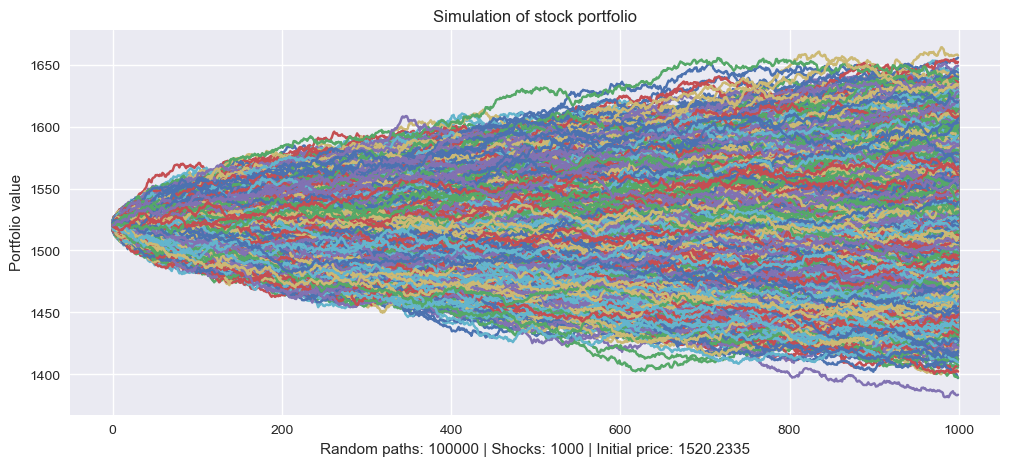

In [90]:
# Monte-Carlo simulation
simulations = 100000
T = 1000
mean_mtx = np.full(shape=(T, len(weights)), fill_value=ret/T).T
portf_simulations = np.full(shape=(T, simulations),fill_value=0.0)
initial_portf = last_price

for i in range(0, simulations):
     Z = np.random.normal(size=(T, len(weights)))
     L = cholesky(cov/T)
     daily_ret = mean_mtx + np.inner(L,Z)
     portf_simulations[:,i] = np.cumprod(np.inner(weights,daily_ret.T)+1)*initial_portf

plt.figure(figsize=(12,5))
plt.style.use('seaborn')
plt.plot(portf_simulations)
plt.ylabel('Portfolio value')
plt.xlabel(
     'Random paths: ' + str(simulations)+\
     ' | Shocks: ' + str(T) +\
     ' | Initial price: ' + str(np.round(last_price,4))
 )
plt.title('Simulation of stock portfolio')
plt.show()

Hay que destacar que en este caso la distribución obtenida es de precios, no de retornos, por lo que al buscar el percentil que deje afuera al 99% de los datos, llegaremos al valor del portafolio, por lo que para obtener el VaR expresado en retorno hay que calcular la variación porcenttual entre el precio de hoy y el valor obtenido.

In [91]:
# VaR by Monte Carlo simulation
#x = np.dot(port_ret.values,weights)
perct = np.percentile(portf_simulations,1) # 99% of confidence
VaR_MC = perct/last_price -1
print('Daily Value at Risk of portfolio is {0:.2f}%'.format(VaR_MC*100))

Daily Value at Risk of portfolio is -3.51%


Como se puede apreciar, este método para estimar el VaR es mucho más complejo de ejecutar, y tampoco genera grandes ventajas contra el VaR paramétrico, ya que al igual que en este útimo, también se hace un supuesto sobre la distribución de los retornos esperados. Además de ser más complejo, tambien es más caro debido a que require un mayor costo computacional mientras mayor sea la simulación.

# Conclusión

El Value at risk es un buen indicador de riesgo, ya que es sencillo e intuitivo, sin embargo, hay que tener presente que no tiene un valor absoluto, sino que depende del método que se elija para calcularlo, además, siempre hay que tener en cuenta los supuestos que hay detrás de cada método y si estos se ajustan al contexto de nuestra inversión.

A continuación se muestra los distintos valores obtenidos para el VaR según cada método.

In [92]:
print(
    'Historical VaR: ' + str(np.round(VaR_hist*100,4)) + '%' + '\n'+\
    'Parametric VaR: ' + str(np.round(VaR_param*100,4)) + '%' + '\n'+\
    'Simulated VaR:  ' + str(np.round(VaR_MC*100,4)) + '%'
)

Historical VaR: -5.7698%
Parametric VaR: -4.5772%
Simulated VaR:  -3.5106%
